## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

The goal of the project was to assist an e-commerce website with decision making. The company has developed a new web page in order to try and increase the number of users who "convert," meaning the number of users who decide to pay for the company's product. The aim is to help the company understand if they should implement this new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

Importing libraries.

In [50]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Read in the `ab_data.csv` data. Store it in `df`.

a. Reading in the dataset and looking at the top few rows:

In [51]:
df = pd.read_csv('ab_data.csv')
df.head(3)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0


b. The number of rows in the dataset.

In [52]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [53]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [54]:
len(df[df['converted']==1]) / len(df['converted'])

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [55]:
len(df[(df['landing_page']=='new_page') & (df['group']!='treatment')])

1928

f. Do any of the rows have missing values?

In [56]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  

a. Dropping the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**.  Storing the new dataframe in **df2**.

In [57]:
df_d = df[((df['landing_page']=='new_page') & (df['group']!='treatment')) | ((df['landing_page']=='old_page') & (df['group']!='control'))]

df2 = df.drop(df_d.index)
df2.head(2)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0


In [58]:
# Double Checking all of the correct rows were removed
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Exploring **df2** int the following cells.

a. Number of unique **user_id** in **df2**?

In [59]:
df2['user_id'].nunique()

290584

b. Identifying repeated **user_id** in **df2**.

In [60]:
user_id_dup = df2[df2['user_id'].duplicated()]['user_id']
user_id_dup

2893    773192
Name: user_id, dtype: int64

c. Row information for the repeat **user_id**? 

In [61]:
df2[df2['user_id']== int(user_id_dup)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [62]:
df2[df2['user_id'].duplicated()].index

Int64Index([2893], dtype='int64')

d. Removing **one** of the rows with a duplicate **user_id**, but keeping dataframe as **df2**.

In [63]:
df2 = df2.drop(df2[df2['user_id'].duplicated()].index)

In [64]:
sum(df2['user_id'].duplicated())

0

`4.` Statistical analyses using **df2**.

a. What is the probability of an individual converting regardless of the page they receive?

In [65]:
len(df2[df2['converted']==1]) / len(df2['converted'])

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [66]:
len(df2[(df2['group']=='control') & (df2['converted']==1)]) / len(df2[df2['group']=='control'])

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [67]:
len(df2[(df2['group']=='treatment') & (df2['converted']==1)]) / len(df2[df2['group']=='treatment'])

0.11880806551510564

d. What is the probability that an individual received the new page?

In [68]:
len(df2[df2['landing_page']=='new_page']) / len(df2['landing_page'])

0.5000619442226688

e. Considering parts (a) through (d) above, we can explain whether there is sufficient evidence to conclude that the new treatment page leads to more conversions.

*In solution to Part(d) it is observed that 50% of the individuals recieved the new page, thus we can say that the dataframe is equally split between the control group and the treatment group. This means that we can easily compare the conversion rate for both group directly (computed in Part(b) and (c)) without normalising the conversions. The conversion rate of the control group (b) is greater than the conversion rate of the treatment group (c). 
The null hypotheses states that the output from the control is equal or greater than the output from the treatment. Thus we can not reject the null hypotheses. This suggests that we have enough evidence to conclude that the new treatment page does not lead to more conversions.*

<a id='ab_test'></a>
### Part II - A/B Test

With the time stamp associated with each event, we can technically run a hypothesis test continuously with each observation.  

However, then the hard question is do we stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do we run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` Lets consider we need to make the decision just based on all the data provided.  If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, the following should be our null and alternative hypotheses? Also what are the converted rates for the old and new pages?

*H0: P(old) >= P(new),
H1: P(old) < P(new)*

`2.` Let's assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Let's use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. The **conversion rate** for $p_{new}$ under the null? 

In [69]:
# P_new = len(df2[(df2['converted']==1)&(df2['group']=='treatment')]) / len(df2['converted'])
P_new = len(df2[(df2['converted']==1)]) / len(df2['converted'])
P_new

# p_new = (df2.converted == 1).mean()

0.11959708724499628

b. The **conversion rate** for $p_{old}$ under the null? <br><br>

In [70]:
# P_old = len(df2[(df2['converted']==1)&(df2['group']=='control')]) / len(df2['converted'])
P_old = P_new

c. What is $n_{new}$, the number of individuals in the treatment group?

In [71]:
n_new = len(df2[df2['group']=='treatment'])
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [72]:
n_old = len(df2[df2['group']=='control'])
n_old

145274

e. Simulating $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Storing these $n_{new}$ 1's and 0's in **new_page_converted**.

In [73]:
new_page_converted = np.random.binomial(n=1, p=P_new, size=n_new)

In [74]:
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

f. Simulating $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Storing these $n_{old}$ 1's and 0's in **old_page_converted**.

In [75]:
old_page_converted = np.random.binomial(n=1, p=P_old, size=n_old)

g. Finding $p_{new}$ - $p_{old}$ for our simulated values.

In [76]:
p_new_simulated = sum(new_page_converted==1)/len(new_page_converted)
p_old_simulated = sum(old_page_converted==1)/len(old_page_converted)
p_new_simulated- p_old_simulated

-0.0017641066163382874

In [77]:
len(new_page_converted),new_page_converted

(145310, array([0, 0, 0, ..., 0, 0, 0]))

h. Creating 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process we used in parts (a) through (g) above. Storing all 10,000 values in a NumPy array called **p_diffs**.

In [78]:
p_diffs = []

new_page_converted_simulation = np.random.binomial(n_new, P_new, 10000)/n_new
old_page_converted_simulation = np.random.binomial(n_old, P_old, 10000)/n_old

In [79]:
p_diffs =new_page_converted_simulation - old_page_converted_simulation

***Confirming length of p_diffs***

In [80]:
len(p_diffs)

10000

i. Ploting a histogram of the **p_diffs**. 

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [81]:
p_diff_ab_data = (len(df2[(df2['group']=='treatment') & (df2['converted']==1)]) / len(df2[df2['group']=='treatment'])) - (len(df2[(df2['group']=='control') & (df2['converted']==1)]) / len(df2[df2['group']=='control']))
p_diff_ab_data

-0.0015782389853555567

In [82]:
(np.array(p_diffs) > p_diff_ab_data).mean()

0.91220000000000001

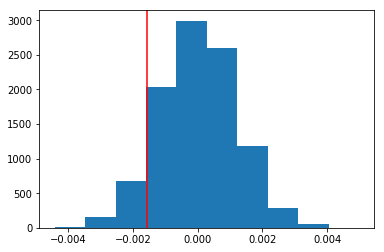

In [83]:
plt.hist(p_diffs);
plt.axvline(p_diff_ab_data, color='red');

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**The P-value is 0.907 which is which greater than the alpha error of 0.05 or 5%. We can conclude that the the conversion rate of the old_page and the conversion rate of the new_page are not equal thus we will reject the null hypotheses.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [84]:
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest


n_old = len(df2[df2['landing_page']=='old_page'])
n_new = len(df2[df2['landing_page']=='new_page'])

In [85]:
c_old = len(df2[(df2['converted']==1) & (df2['landing_page']=='old_page')])
c_new = len(df2[(df2['converted']==1) & (df2['landing_page']=='new_page')])
print(c_old)
print(c_new)

17489
17264


m. Using `stats.proportions_ztest` to compute our test statistic and p-value.

In [86]:
stat, pval = proportions_ztest([c_new,c_old], [n_new,n_old],alternative='larger' )
pval

0.90505831275902449

n. How do the z-score and p-value that we computed in the previous question mean for the conversion rates of the old and new pages? Are the findings in parts **j.** and **k.** valid?

***The p-value computed using the inbuilt proportions_ztest is the same as that calcalated in parts 'j' and 'k'. In the proportions_ztest we assumed that the probability p_old and p_new are the same under the null hypotheses. The generated p=value informs that the null hypotheses should be rejected as it is again more than the aplha error of 0.05. We can conclude that p_old and p_new are not equal. ***

<a id='regression'></a>
### Part III - A regression approach

`1.` The result we achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Note that each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**We will perform logistic regression.**

b. The goal is to use **statsmodels** to fit the regression model we specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, we first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Adding an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [87]:
df2['ab_page'] = df2['group']

In [88]:
df2['ab_page'].replace({'treatment': '1', 'control': '0'}, inplace=True)

In [89]:
df2[['new_page','old_page']] = pd.get_dummies(df2['landing_page'])
df2['intercept'] = 1
df2.head(3)

,user_id,timestamp,group,landing_page,converted,ab_page,new_page,old_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,0,1,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,0,1,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1


In [90]:
df2['ab_page'] = df2['ab_page'].astype(np.uint8)

In [91]:
df2

,user_id,timestamp,group,landing_page,converted,ab_page,new_page,old_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,0,1,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,0,1,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,0,1,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,0,0,1,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,0,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,0,0,1,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,0,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,0,1


c. Useing **statsmodels** to instantiate our regression model on the two columns we created in part b., then fitting the model using the two columns we created in part **b.** to predict whether or not an individual converts. 

In [92]:
Logit_ml = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
result = Logit_ml.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. The summary of our model is mentioned below.

In [93]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-08-23 12:07 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value we found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with our regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**The null hyphotheses is that the predicter variable (ab_page) has no statistical significance to the response variable(converted). The p-value of ab_page is greater than the alpha arror of 0.05 this means that we fail to reject the null hypotheses. Conclusion is that ab_page is not significant.***

***The logisitic regression informs that the relevance of a predictor variable in terms of our response variable. In this class we can say that abP_page or the camparison between the old page and new page provides no statistical insight. In conclusion, A/B testing using the new page vs the old page is not recommended.**

f. Now, we are considering other things that might influence whether or not an individual converts.  Let's discuss why it is a good idea to consider other factors to add into our regression model.  Are there any disadvantages to adding additional terms into our regression model?

***As we can see ab_page is not a good predictor variable so we should consider exploring other potential variables that may prove to be statistically significant to the response variable. The disadvantage of introducing additional variables is that they can be multicollinear, meaning they can be interdependent on each other thus skewing the results of the regression model. Additionally there is no gurantee that the new terms are relevant to our regression task.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. We will need to read in the **countries.csv** dataset and merge together our datasets on the appropriate rows. 

Does it appear that country had an impact on conversion? 

In [94]:
df_countries = pd.read_csv('countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [95]:
df3 = pd.merge(df2,df_countries, on='user_id')
df3.head(4)

,user_id,timestamp,group,landing_page,converted,ab_page,new_page,old_page,intercept,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,0,1,1,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,0,1,1,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1,US


In [96]:
df3[['CA','UK','US']] = pd.get_dummies(df3['country'])
df3.head()

,user_id,timestamp,group,landing_page,converted,ab_page,new_page,old_page,intercept,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,0,1,1,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,0,1,1,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,0,1,1,US,0,0,1


In [97]:
Logit_lm_countries = sm.Logit(df3['converted'],df3[['intercept','ab_page','CA','UK']])
result = Logit_lm_countries.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-08-23 12:07 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
CA           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

**The p-values for ab_page, CA and UK are greater than the alpha error thus they are again statistically insignifcant to the response variable. Thus we fail to reject the null hypotheses. In co**

h. Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

The summary results, and our conclusions based on the results.

In [98]:
df3['new_CA'] = df3['new_page']*df3['CA']
df3['old_CA'] = df3['old_page']*df3['CA']
df3['new_UK'] = df3['new_page']*df3['UK']
df3['old_UK'] = df3['old_page']*df3['UK']
df3['new_US'] = df3['new_page']*df3['US']
df3['old_US'] = df3['old_page']*df3['US']
df3 = df3.drop(['group','landing_page','country'], axis=1)
df3.head()

,user_id,timestamp,converted,ab_page,new_page,old_page,intercept,CA,UK,US,new_CA,old_CA,new_UK,old_UK,new_US,old_US
0,851104,2017-01-21 22:11:48.556739,0,0,0,1,1,0,0,1,0,0,0,0,0,1
1,804228,2017-01-12 08:01:45.159739,0,0,0,1,1,0,0,1,0,0,0,0,0,1
2,661590,2017-01-11 16:55:06.154213,0,1,1,0,1,0,0,1,0,0,0,0,1,0
3,853541,2017-01-08 18:28:03.143765,0,1,1,0,1,0,0,1,0,0,0,0,1,0
4,864975,2017-01-21 01:52:26.210827,1,0,0,1,1,0,0,1,0,0,0,0,0,1


In [99]:
Logitlm_multipls_countries = sm.Logit(df3['converted'],df3[['intercept','new_CA','new_UK','new_US','old_CA','old_UK']])
result = Logitlm_multipls_countries.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-08-23 12:07 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
new_CA       -0.0850    0.0384    -2.2157  0.0267  -0.1601  -0.0098
new_UK        0.0051    0.0188     0.2710  0.7864  -0.0317   0.0419
new_US       -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
old_CA       -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
old_UK       -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
==================================================================

"""

**In this regression we can observe that the p-value for new_CA is less than the alpha error or 0.05 thus this is the only predictor variable which is statistically significant to the response variable.**

### Conclusion


##### A/B Testing concluded indicated that treatment group had a higher rate of convrsion and thus the new page should be implimented. However, Ab_page is not statistically significant to converted so it may not be considered as a good predictor variable. Countries of the users also may not be considered as a good predictor variable. We need to explore the possibility of other variables as predictor variables. A/B Testing should only be performed after checking the statistic significance of said variables.